In [0]:
import os
os.chdir("./drive/My Drive/179skill")

In [0]:
import pyGM as gm
import numpy as np
import matplotlib.pyplot as plt
import random
import time
%matplotlib inline         

In [0]:
def logit(z): return 1./(1.+np.exp(-z))

In [0]:
def generate_players(num_of_players, skill_cap):
    ## returns a list of player's skill
    return [round(random.uniform(0,skill_cap),2) for i in range(num_of_players)]


def generate_games(players, num_of_games, scale=0.3, style='pygm'):

    if style == 'pystan':
        
        player1=[]
        player2=[]
        outcome=[]
        for i in range(num_of_games):
            p1,p2 = random.sample(range(len(players)),2)
            win_rate=logit(scale*(players[p1]-players[p2]) )

            ##pystan player id is ONE based
            player1.append(p1+1)
            player2.append(p2+1)
            
            outcome.append(*random.choices([1,0],weights=[win_rate,1-win_rate]))

        return player1,player2,outcome
    
    elif style == 'pygm':
        games=[]
        for i in range(num_of_games):
            p1,p2 = random.sample(range(len(players)),2)
            win_rate=logit(scale*(players[p1]-players[p2]) )
            
            games.append((p1,p2,*random.choices([1,-1],weights=[win_rate,1-win_rate])))
        return games
    
    assert False 


In [0]:
def skill_MSE(predicted_skill, true_skill):
    return sum( (predicted_skill[i]-true_skill[i])**2 for i in range(len(predicted_skill)) )/len(predicted_skill)

def prediction_accuracy(bel, X, Pwin, true_players, num_valid_game=1000, scale=0.3):
    
    # error = 0
    # num_of_players= len(true_players)
    
    # for i in range(num_of_players):
    #     opponents = random.sample([x for x in range(num_of_players) if x != i],num_of_opponents)

    #     for j in opponents:
    #         true_win_rate=logit(scale*(true_players[i] - true_players[j]) )
    
    #         if i<j:
    #             prediction = (bel[i]*bel[j]*gm.Factor([X[i],X[j]],Pwin)).table.sum() 
    #         else:
    #             prediction = (bel[i]*bel[j]*gm.Factor([X[i],X[j]],1-Pwin)).table.sum()

    #         error += (true_win_rate - prediction) **2

    # return error/(num_of_players*num_of_opponents)

    valid_games = generate_games(true_players, num_valid_game, scale, style='pygm')

    acc=0

    for g in valid_games:

        i,j,result=int(g[0]),int(g[1]),int(g[2])
        if i<j:
            prediction = (bel[i]*bel[j]*gm.Factor([X[i],X[j]],Pwin)).table.sum() 
        else:
            prediction = (bel[i]*bel[j]*gm.Factor([X[i],X[j]],1-Pwin)).table.sum()
        predicted_result=random.choices([1,-1],[prediction,1-prediction])[0]
        acc+=int(predicted_result == result)

    return acc/num_valid_game

First test: 

In [45]:
result_skill_MSE_10_100=[]
result_prediction_10_100=[]
for num_of_players in [10,20,30,40,50,60,70,80,90,100,150,200,300,500]:
  starting_time=time.time()
  scale=0.5
  print("\n\nStarting num_of_players =",num_of_players)

  nplayers = num_of_players
  nlevels = 10   # let's say 10 discrete skill levels

  result_skill_MSE={}
  result_prediction={}
  print("num_of_games = ",end='')
  for num_of_games in [10,20,50,100,500,700,1000,3000,5000]:
      
      trials_result_skill=[]
      trials_result_prediction=[]
      print(num_of_games,end=',')
      for trials in range(10):
          true_players = generate_players(num_of_players,nlevels)
          train_games = generate_games(true_players, num_of_games, scale, style='pygm')

          # print("true skills:",true_players)

          # nplayers = max( [max(g[0],g[1]) for g in games] )+1 #number of players

          # Make variables for each player; value = skill level
          X = [None]*nplayers
          for i in range(nplayers):
              X[i] = gm.Var(i, nlevels)   

          # Information from each game: what does Pi winning over Pj tell us?
          #    Win probability  Pr[win | Xi-Xj]  depends on skill difference of players
          Pwin = np.zeros( (nlevels,nlevels) )
          for i in range(nlevels):
              for j in range(nlevels):
                  diff = i-j                   # find the advantage of Pi over Pj, then 
                  Pwin[i,j] = (1./(1+np.exp(-scale*diff)))  # Pwin = logistic of advantage

          # before any games, uniform belief over skill levels for each player:
          factors = [ gm.Factor([X[i]],1./nlevels) for i in range(nplayers) ]

          # Now add the information from each game:
          for g in train_games:
              P1,P2,win = g[0],g[1],g[2]
              if P1>P2: P1,P2,win=P2,P1,-win  # (need to make player IDs sorted...)
              factors.append(gm.Factor([X[P1],X[P2]], Pwin if win>0 else 1-Pwin) )


          starting=time.time()
          model = gm.GraphModel(factors)
          model.makeMinimal()  # merge any duplicate factors (e.g., repeated games)
          # print("spent:",round(time.time()-starting,3))


          if model.nvar < 0:       # for very small models, we can do brute force inference:
              jt = model.joint()
              jt /= jt.sum()       # normalize the distribution and marginalize the table
              bel = [jt.marginal([i]) for i in range(nplayers)] 

          else:                    # otherwise we need to use some approximate inference:
              from pyGM.messagepass import LBP, NMF
              #lnZ,bel = LBP(model, maxIter=10, verbose=False)   # loopy BP
              lnZ,bel = NMF(model, maxIter=10, verbose=False)  # Mean field


          predicted_players = [ bel[i].table.dot(np.arange(nlevels)) for i in range(nplayers)]

          trials_result_skill.append( skill_MSE(predicted_players,true_players) )
          trials_result_prediction.append( prediction_accuracy(bel, X, Pwin, true_players, num_valid_game=1000, scale=scale) )
      
      result_skill_MSE[num_of_games]=trials_result_skill
      result_prediction[num_of_games]=trials_result_prediction
  print()
  print("total time spent:",round(time.time()-starting_time,2))
  print(result_skill_MSE)
  print(result_prediction)
  result_skill_MSE_10_100.append(result_skill_MSE)
  result_prediction_10_100.append(result_prediction)



Starting num_of_players = 10
num_of_games = 10,20,50,100,500,700,1000,3000,5000,
total time spent: 1302.15
{10: [3.6601592820950293, 4.856499098141223, 5.96247309759182, 3.20344717324111, 7.701105977231956, 5.645569031303085, 8.085657621504659, 3.4907355057310943, 4.196992074248885, 6.717350296777528], 20: [3.9112149771943523, 2.1100254992323104, 3.252142509208047, 7.469542402708001, 8.098086593614864, 3.7074542254051535, 2.7577320959034193, 0.8118874845727724, 2.439469909909426, 4.615541008492641], 50: [2.6010536976817336, 3.8114305812438216, 2.934706469619792, 2.1196212646847736, 1.011452100190151, 3.07157901464542, 1.6188099750986276, 5.04554084324337, 3.505838043071436, 2.2023127366942954], 100: [0.6768174712828202, 3.901416618265485, 1.4149455932304666, 0.5957660849194895, 5.279676649775204, 1.4263973377978514, 0.5968386883312797, 1.8625413367509054, 3.554453989684439, 0.38242444951044524], 500: [3.516174402695049, 1.0133076020751315, 1.9371520689554422, 1.0598195957394805, 0.13

In [46]:
print(result_skill_MSE_10_100)
print(result_prediction_10_100)

[{10: [3.6601592820950293, 4.856499098141223, 5.96247309759182, 3.20344717324111, 7.701105977231956, 5.645569031303085, 8.085657621504659, 3.4907355057310943, 4.196992074248885, 6.717350296777528], 20: [3.9112149771943523, 2.1100254992323104, 3.252142509208047, 7.469542402708001, 8.098086593614864, 3.7074542254051535, 2.7577320959034193, 0.8118874845727724, 2.439469909909426, 4.615541008492641], 50: [2.6010536976817336, 3.8114305812438216, 2.934706469619792, 2.1196212646847736, 1.011452100190151, 3.07157901464542, 1.6188099750986276, 5.04554084324337, 3.505838043071436, 2.2023127366942954], 100: [0.6768174712828202, 3.901416618265485, 1.4149455932304666, 0.5957660849194895, 5.279676649775204, 1.4263973377978514, 0.5968386883312797, 1.8625413367509054, 3.554453989684439, 0.38242444951044524], 500: [3.516174402695049, 1.0133076020751315, 1.9371520689554422, 1.0598195957394805, 0.13446489463202166, 0.2307588071360005, 1.3083364532464918, 2.5316299731194265, 0.2313659772038618, 2.557782765

In [0]:
import matplotlib.pyplot as plt

def plot_result(result,num_of_players):

    plt.figure(figsize=(20,15))
    for i,nplayers in enumerate(num_of_players):
        d = result[i]
        x = np.array([k for k in d])
        all_trials = np.array([d[k] for k in d])
        y = np.mean(all_trials, axis = 1)    
        std = np.std(all_trials, axis = 1)
    
        plt.scatter(x, y, marker='.' ,label = str(nplayers)+'players',linewidths=0.01)
        plt.errorbar(x, y, yerr = std, capsize = 5)
    plt.legend()
    plt.show()

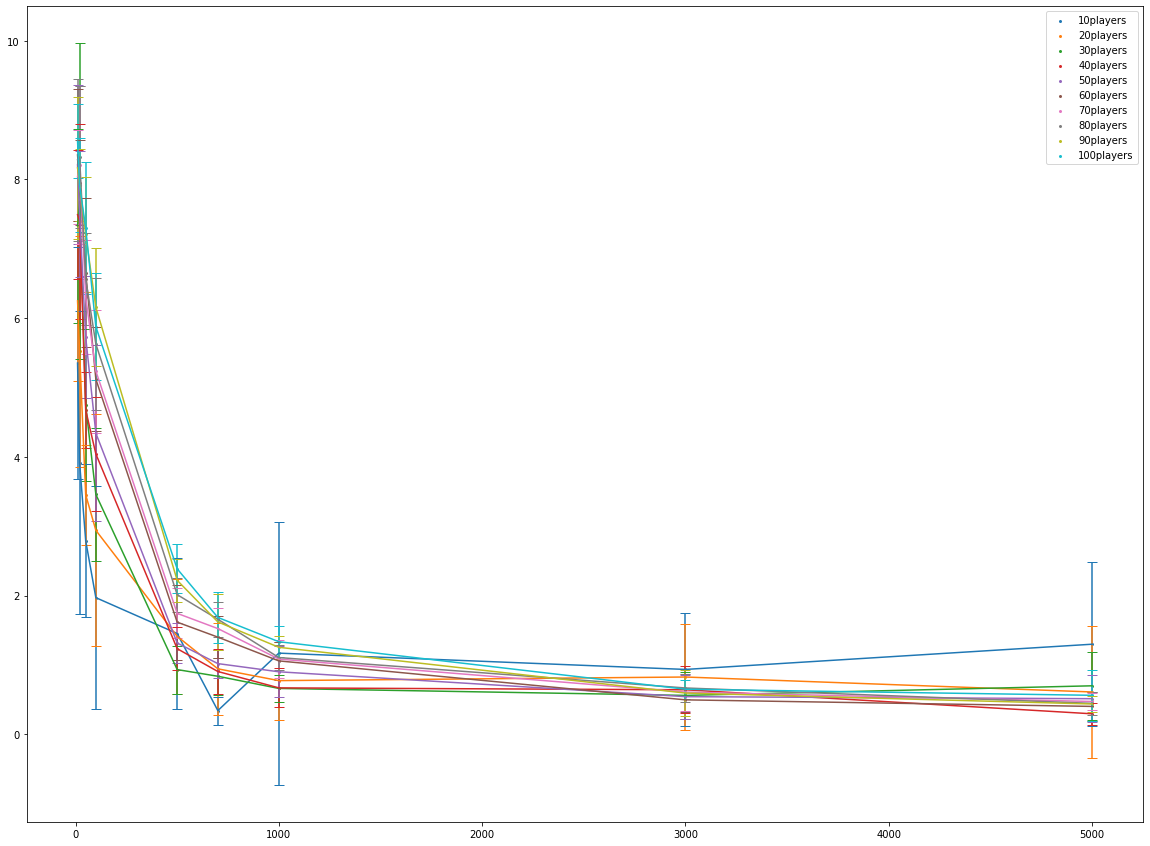

In [52]:
plot_result(result_skill_MSE_10_100[:10],[10,20,30,40,50,60,70,80,90,100,150,200,300,500][:10])

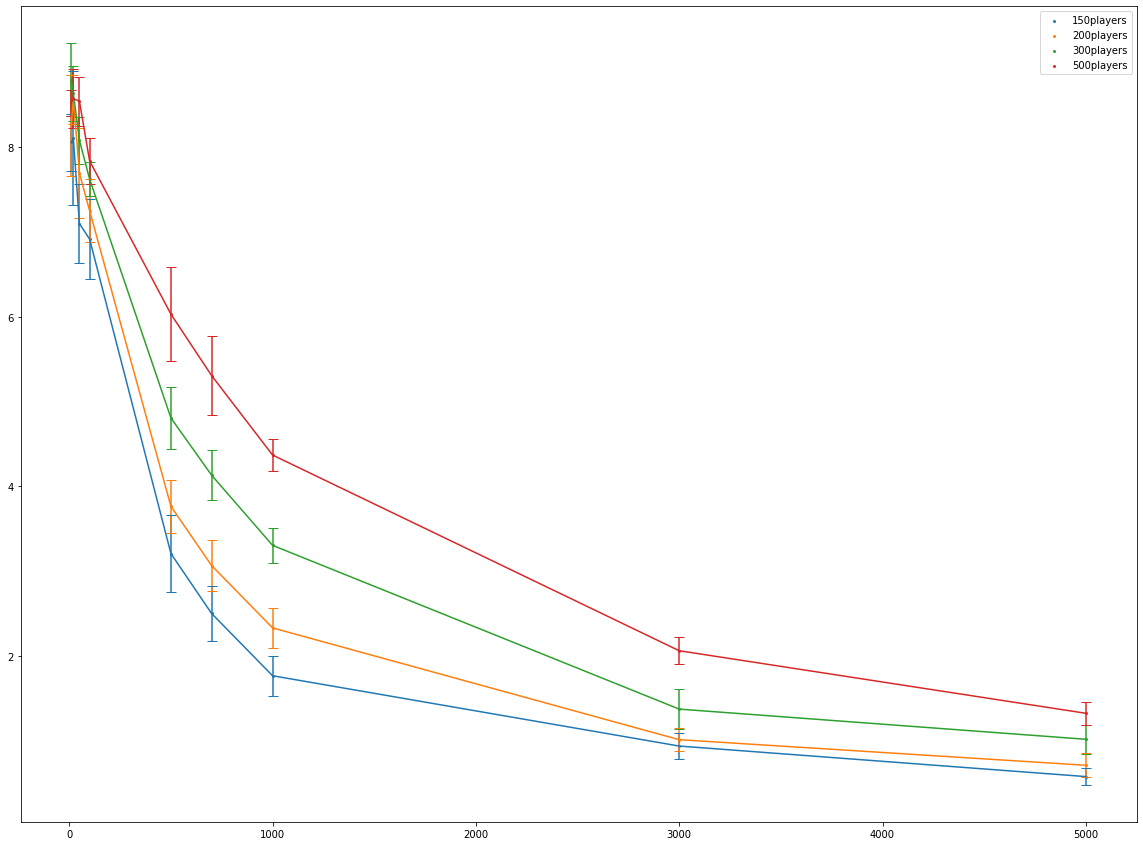

In [53]:
plot_result(result_skill_MSE_10_100[10:],[10,20,30,40,50,60,70,80,90,100,150,200,300,500][10:])

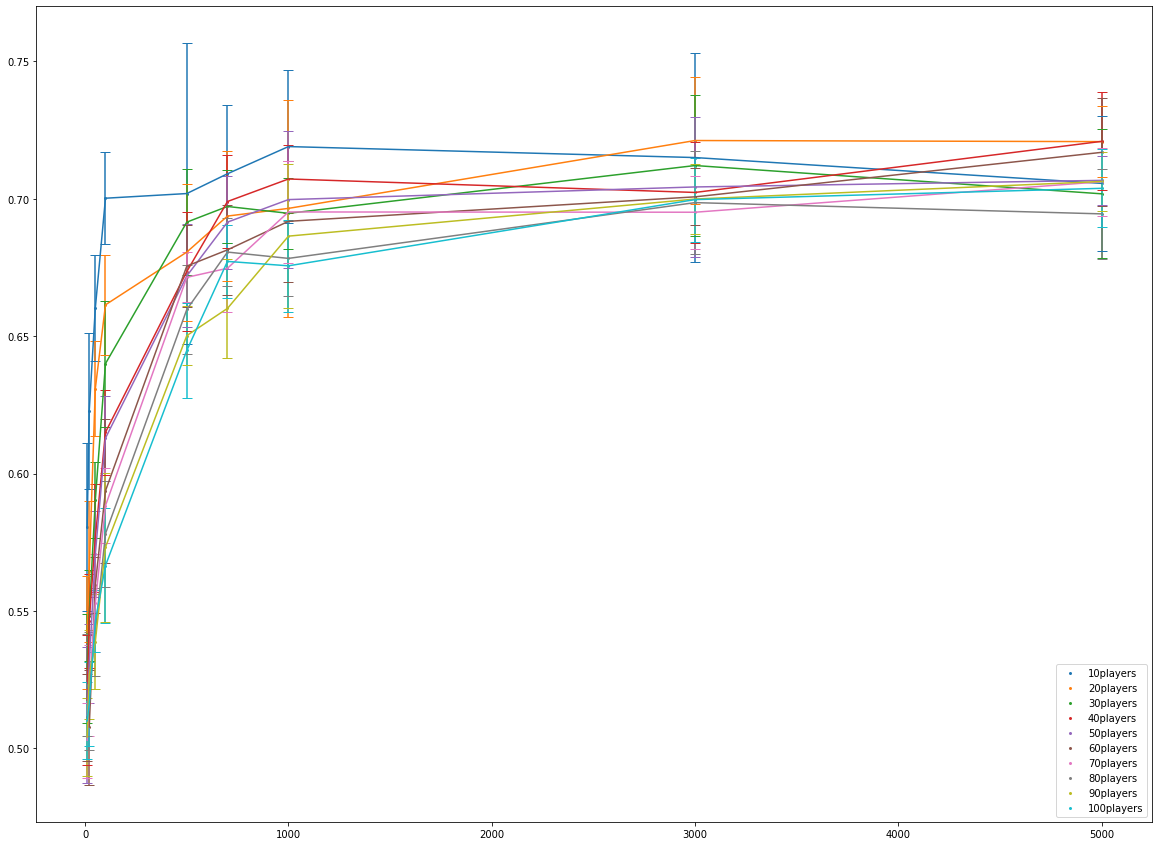

In [54]:
plot_result(result_prediction_10_100[:10],[10,20,30,40,50,60,70,80,90,100,150,200,300,500][:10])

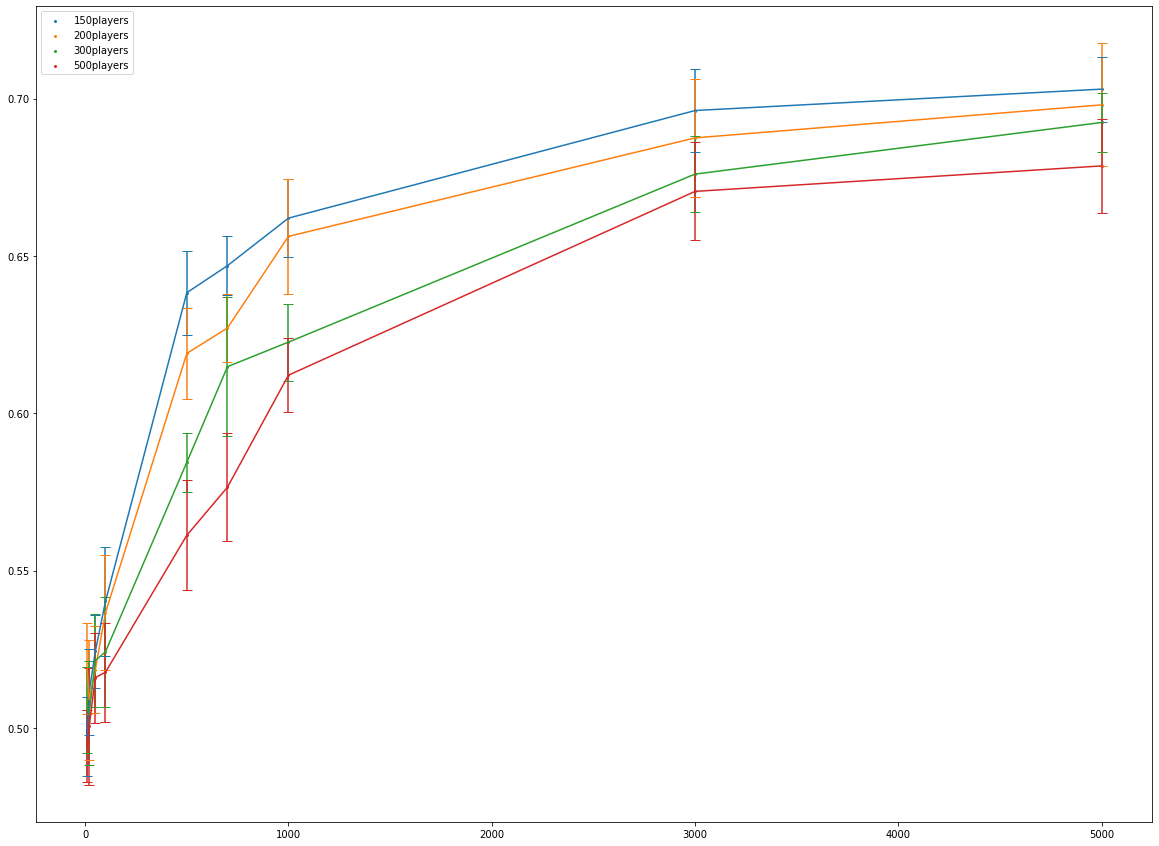

In [55]:
plot_result(result_prediction_10_100[10:],[10,20,30,40,50,60,70,80,90,100,150,200,300,500][10:])

Second test, test 100+ players

In [0]:
result_skill_MSE_100_1000=[]
result_prediction_100_1000=[]
for num_of_players in [100,125,150,175,200,300,500,700,1000]:
  starting_time=time.time()
  scale=0.5
  print("\n\nStarting num_of_players =",num_of_players)

  nplayers = num_of_players
  nlevels = 10   # let's say 10 discrete skill levels

  result_skill_MSE={}
  result_prediction={}
  print("num_of_games = ",end='')
  for num_of_games in [10,500,700,1000,3000,5000,7000,10000]:
      
      trials_result_skill=[]
      trials_result_prediction=[]
      print(num_of_games,end=',')
      for trials in range(10):
          true_players = generate_players(num_of_players,nlevels)
          train_games = generate_games(true_players, num_of_games, scale, style='pygm')

          # print("true skills:",true_players)

          # nplayers = max( [max(g[0],g[1]) for g in games] )+1 #number of players

          # Make variables for each player; value = skill level
          X = [None]*nplayers
          for i in range(nplayers):
              X[i] = gm.Var(i, nlevels)   

          # Information from each game: what does Pi winning over Pj tell us?
          #    Win probability  Pr[win | Xi-Xj]  depends on skill difference of players
          Pwin = np.zeros( (nlevels,nlevels) )
          for i in range(nlevels):
              for j in range(nlevels):
                  diff = i-j                   # find the advantage of Pi over Pj, then 
                  Pwin[i,j] = (1./(1+np.exp(-scale*diff)))  # Pwin = logistic of advantage

          # before any games, uniform belief over skill levels for each player:
          factors = [ gm.Factor([X[i]],1./nlevels) for i in range(nplayers) ]

          # Now add the information from each game:
          for g in train_games:
              P1,P2,win = g[0],g[1],g[2]
              if P1>P2: P1,P2,win=P2,P1,-win  # (need to make player IDs sorted...)
              factors.append(gm.Factor([X[P1],X[P2]], Pwin if win>0 else 1-Pwin) )


          starting=time.time()
          model = gm.GraphModel(factors)
          model.makeMinimal()  # merge any duplicate factors (e.g., repeated games)
          # print("spent:",round(time.time()-starting,3))


          if model.nvar < 0:       # for very small models, we can do brute force inference:
              jt = model.joint()
              jt /= jt.sum()       # normalize the distribution and marginalize the table
              bel = [jt.marginal([i]) for i in range(nplayers)] 

          else:                    # otherwise we need to use some approximate inference:
              from pyGM.messagepass import LBP, NMF
              #lnZ,bel = LBP(model, maxIter=10, verbose=False)   # loopy BP
              lnZ,bel = NMF(model, maxIter=10, verbose=False)  # Mean field


          predicted_players = [ bel[i].table.dot(np.arange(nlevels)) for i in range(nplayers)]

          trials_result_skill.append( skill_MSE(predicted_players,true_players) )
          trials_result_prediction.append( prediction_accuracy(bel, X, Pwin, true_players, num_valid_game=1000, scale=scale) )
      
      result_skill_MSE[num_of_games]=trials_result_skill
      result_prediction[num_of_games]=trials_result_prediction
  print()
  print("total time spent:",round(time.time()-starting_time,2))
  print(result_skill_MSE)
  print(result_prediction)
  result_skill_MSE_100_1000.append(result_skill_MSE)
  result_prediction_100_1000.append(result_prediction)



Starting num_of_players = 100
num_of_games = 10,500,700,